# 3.2 Overlap in Lexical and Literary Vocabulary: Digging Deeper

In order to research the relationship between lexical and literary vocabularies in more detail we will look at individual literary texts. Which compositions have more and which have less overlap with the lexical vocabulary?

Longer texts will have more vocabulary items (and Multiple Word Expressions) in common with the lexical corpus than shorter texts, but that does not mean much. We will therefore compare literary compositions by means of a normalized measure.

### 3.2.0 Preparation

This notebook uses some files that were downloaded or produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb). Run that notebook first, before this one. 

First import the necessary libraries. If you are running this notebook in Jupyter Lab you will need to install the Jupyter Lab ipywidgets extension (see [Introduction](../1_Preliminaries/1_Introduction.md), section 1.2.2.1). 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdm
from tqdm.auto import tqdm
tqdm.pandas() # initiate pandas support in tqdm, allowing progress_apply() and progress_map()
import pandas as pd
from ipywidgets import interact
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import zipfile
import json

Open the file `litlines.p` which was produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb). The file contains the pickled version of the DataFrame `lit_lines` in which the literary ([epsd2/literary](http://oracc.org/epsd2/literary)) corpus is represented in line-by-line format.

In [2]:
lit_lines = pd.read_pickle('output/litlines.p')

#### 3.2.0.1 Literary: By Composition
The line-by-line representation that was prepared in the previous notebook will be transformed into a composition-by-composition representation. The DataFrame `lit_lines` includes the column `lemma_mwe` in which each line is represented as a sequence of lemmas and/or Multiple Word Expressions (lemmas connected by underscores). The `pandas` `groupby()` function is used here to group on `id_text` and `text_name`. The aggregate function for the `lemma_mwe` column in this case is simply `' '.join`: all the entries (representing lines) are concatenated to form one long sequence of lemmas in a single string representing one composition.

The field `id_text` in the resulting DataFrame has the form 'epsd2/literary/P254863'. In fact, we only need the last 7 characters of that string (the P, Q, or X number of the text), because all texts derive from the same project. We can simplify the `id_text` string with a list comprehension.

In [3]:
lit_comp = lit_lines.groupby(
    [lit_lines["id_text"]]).aggregate(
    {"lemma_mwe": ' '.join}).reset_index()
lit_comp['id_text'] = [id[-7:] for id in lit_comp["id_text"]]
lit_comp[25:35]

,id_text,lemma_mwe
25,P254863,iri[city]n silim[healthy]v/i tag[touch]v/t lul...
26,P254864,kugzu[wise]aj namkugzu[wisdom]n na-an-ak-x[na]...
27,P254865,lu[person]n_niŋgina[truth]n zi[life]n utud[bea...
28,P254866,niŋ[thing]n_gu[neck]n_ŋar[place]v/t niŋ[thing]...
29,P254867,dubsar[scribe]n mu[name]n ni₂-x[na]na igi[eye]...
30,P254868,x-x[na]na mu[name]n diš[one]nu zu[know]v/t x-n...
31,P254869,dubsar[scribe]n emegir[sumerian]n nu-un-zu-x[n...
32,P254870,dubsar[scribe]n_tur[small]v/i bar[outside]n ni...
33,P254871,šah[pig]n šu[hand]n kar[flee]v/i iginzu[as-if]...
34,P254872,amaʾatud[slave]n sulum[contempt]n in-na-x[na]n...


The result is a DataFrame with two columns: `id_text`, and `lemma_mwe`. Each row represents a literary composition from the [epsd2/literary](http://oracc.org/epsd2/literary) corpus. Each cell in the column `lemma_mwe` contains a sequence of lemmas of one composition (with MWEs connected by underscores).

### 3.2.0.2 Text Length and Number of Unique Lemmas
For each literary composition we need to know the text length and the number of unique lemmas. We will use these numbers to weed out documents that are to short and to normalize the number of hits (the number of lemmas shared with the lexical corpus).

In [4]:
def lit_stats(lemmas):
    lemmas = lemmas.split()
    lemmas = [lemma for lemma in lemmas if not '[na]na' in lemma] # remove unlemmatized words
    length = len(lemmas) # number of lemmatized words
    lex_var = len(set(lemmas))
    return ' '.join(lemmas), length, lex_var

In [5]:
lit_comp['lemma_mwe'], lit_comp['length'], lit_comp['lex_var'] = \
    zip(*lit_comp['lemma_mwe'].progress_map(lit_stats))
lit_comp = lit_comp.loc[lit_comp['length'] > 0] # remove compositions that have no lemmatized content

### 3.2.1 Document Term Matrix

The literary corpus is transformed into a Document Term Matrix (or DTM), a table in which each column represents a lemma and each row represents a Sumerian composition. Each cell contains a number indicating the frequency of that word  in a particular composition.

Since we are interested in the usage of lexical vocabulary in literary texts, we may skip all words that are not available in the lexical corpus, saving a considerable amount of memory. We can do that by defining a vocabulary, derived from the data produced in the previous notebook ([3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb)). The vocabulary is sorted (by alphabet) so that the columns in the DTM will be in alphabetical order as well.

In [6]:
with open('output/lex_vocab.txt', 'r', encoding = 'utf8') as r:
    lex_vocab = r.read().splitlines()
lex_vocab.sort()

In order to create the DTM we use the function `CountVectorizer()` (from the `Sklearn` package), a very flexible tool with many possible parameters. The most common use case is a corpus of raw documents (probably in English), each of them consisting of a text string that needs to be pre-processed  and tokenized (turned into a list of words or lemmas) before anything else can be done. Default pre-processing includes, for instance, lowercasing the entire text (so that thursday, Thursday, and THURSDAY will all be recognized as the same lemma) and removal of punctuation and numbers. Default tokenizers assume that the text is in a modern (western) language, taking spaces, hyphens, and punctuation marks as word dividers. The structure of the [ORACC](http://oracc.org) data is much simpler than that. Pre-processing is unnecessary, and tokenization should split the string *only* at blank spaces.

This can be achieved by defining custom tokenizer/preprocessor functions, and tell `Countvectorizer()` to use these. The custom tokenizer consists of the standard Python function `split()`; the preprocessor function does nothing at all.

The parameter `vocabulary` is set to the variable `lex_vocab` (created above), which includes all lemmas and lexical entries in the lexical corpus. 

`CountVectorizer()` stores the results in a sparse matrix which notes the position and value of non-zero entries. In transforming the output to a Pandas DataFrame, we need to use the `toarray()` method, which will transform the sparse matrix into a regular matrix.

In [7]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), preprocessor=lambda x: x, vocabulary=lex_vocab)
#Alternative way to do the same thing:
#cv = CountVectorizer(token_pattern = r'[^ ]+', vocabulary=lex_vocab)
dtm = cv.fit_transform(lit_comp['lemma_mwe'])
lit_df = pd.DataFrame(dtm.toarray(), columns= cv.get_feature_names(), index=lit_comp["id_text"])
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_apin[plow]n,a[arm]n_bad[open]v/t,a[arm]n_bad[wall]n,a[arm]n_badsi[parapet]n,a[arm]n_bala[turn]v/t,a[arm]n_be[diminish]v/t,a[arm]n_da[line]n,a[arm]n_dabašin[object]n,...,šuʾabdu[1]wn,šuʾi[barber]n,šuʾi[barber]n_egir[back]n,šuʾi[barber]n_gin[firm]v/i,šuʾi[barber]n_gina[offering]n,šuʾi[barber]n_gu[neck]n,šuʾi[barber]n_lugal[king]n,šuʾi[barber]n_saŋ[head]n,šuʾu[stone]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P209784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252215,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000823,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000825,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The resulting DataFrame lit_df has a row for each *literary* composition and it has a column for every lemma/expression in the *lexical* corpus. The number of columns, therefore, should correspond to the size of the lexical vocabulary in the Venn diagram produced in the previous notebook:

![venn diagram 3](viz/venn_3.png)

As we have seen in the previous notebook, many of these words/expressions do not appear in the [epsd2/literary](http://oracc.org/epsd2/literary) corpus, and thus all cells in those columns are 0. If we remove those columns, we get the vocabulary that is shared between the lexical corpus and the literary corpus (the intersection of the circles in the Venn diagram). The left side of the Venn diagram (the literary vocabulary that does not appear in lexical texts) is not represented in the DTM. This DTM, therefore, should only be used to research the *intersection* between the two (literary and lexical) vocabularies.

> The number of non-zero columns does not *exactly* correspond to the size of the intersection in the Venn diagram. The reason is that a word like **ašrinna\[object\]n**, a word that in the literary corpus only appears in the MWE **kid\[mat\]n_ašrinna\[object\]n**, is counted as a match in the Venn diagram, but only appears in the column **kid\[mat\]n_ašrinna\[object\]n** in the DTM. See [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb) section 3.1.3.1.

In [8]:
lit_df = lit_df.loc[: , lit_df.sum(axis=0) != 0].copy()
vocab = lit_df.columns # `vocab` is a list with all the vocabulary items currently in `lit_df`
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_bad[open]v/t,a[arm]n_bala[turn]v/t,a[arm]n_dar[split]v/t,a[arm]n_daŋal[wide]v/i,a[arm]n_durah[goat]n,a[arm]n_e[leave]v/i,a[arm]n_gab[left]n,a[arm]n_gal[big]v/i,...,šutum[storehouse]n,šutur[garment]n,šuziʾana[1]dn,šuš[cover]v/t,šušana[one-third]nu,šuši[sixty]nu,šušin[1]sn,šušru[distressed]v/i,šuʾi[barber]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P209784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252215,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000823,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000825,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The variable `vocab` is a list that includes all lemmas and MWEs that are shared by the literary corpus and the lexical corpus. Save this list for use in section 3.3.

In [9]:
with open('output/lit_lex_vocab.txt', 'w', encoding = 'utf8') as w:
    w.write('\n'.join(vocab))

### 3.2.2 Number of Lexical/Literary Matches per Literary Composition. 
The sum of each row of the DTM equals the sum of the frequencies of all words/expressions that a composition shares with the lexical corpus. Instead of adding up the frequencies, however, it makes more sense to count the number of non-zero entries. This number (`nmatches`) represents the number of unique words and MWEs used in a particular literary composition (represented by a row) that are found in the lexical corpus. We can do so with the Pandas method `astype(bool)`, which will yield 0 for each zero entry and 1 for each non-zero entry. 
```python
lit_df["n_matches"] = lit_df.astype(bool).sum(axis=1)
```
By adding more columns to the DTM (in this case the column `n_matches`) it becomes necessary to indicate on which columns we want to perform our calculations. The variable `vocab` is a list of all lemmas and MWEs that are shared by the lexical and literary corpora - and therefore it is also a list of all the relevant column names in the DTM. At this point in the script, adding this restriction to the code (in the form `lit_df[vocab]`) is a safety measure that ensures that running the line twice (for whatever reason) results in the same output and does not take `n_matches` as part of the summation.

In [10]:
lit_df["n_matches"] = lit_df[vocab].astype(bool).sum(axis=1)

#### 3.2.2.1 Adding Metadata
Above, we computed various statistics for each of the literary compositions. The catalog file for [epsd2/literary](http://oracc.org/epsd2/literary) contains further information (such as the composition name). Parsing the `catalogue.json` of an [ORACC](http://oracc.org) project is discussed in more detail in section [2.1.1](../2_1_Data_Acquisition_ORACC/2_1_1_parse-json-cat.ipynb).

In [11]:
file = "jsonzip/epsd2-literary.zip" # The ZIP file was downloaded in the previous notebook
z = zipfile.ZipFile(file) 
st = z.read("epsd2/literary/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
#The important information, giving the title of the literary text is sometimes found in 
# `designation` and sometimes in `subgenre`. Merge those two fields.
cat_df.loc[cat_df.designation.str[:13] == "CDLI Literary", "designation"] = cat_df.subgenre
# Exemplars have a P number (`id_text`), composite texts have a Q number (`id_composite`).
# Merge those two in `id_text`.
cat_df["id_text"] = cat_df["id_text"].fillna(cat_df["id_composite"])
# Keep only `id_text` and `designation`.
cat_df = cat_df[["id_text", "designation"]]

Merge text length and number of unique lemmas in `lit_comp` with the number of lexical matches from the DTM (`lit_df`) by the shared field `id_text`. Merge the resulting DataFrame (`lit_df2`) with the metadata (`cat_df`). The merge method is "inner," which means that only those rows that exist in all three DataFrames will end up in the new DataFrame. Thus, the compositions with 0 lemmatized words, which were eliminated above, will not re-surface in the new DataFrame.

In [12]:
lit_df2 = pd.merge(lit_comp[["id_text", "length", "lex_var"]], lit_df['n_matches'], on = 'id_text', how = 'inner')
lit_df2 = pd.merge(cat_df, lit_df2, on = 'id_text', how = 'inner')
lit_df2

,id_text,designation,length,lex_var,n_matches
0,P209784,"Ontario 2, 506",5,5,5
1,P251427,"CUSAS 38, 09",163,108,102
2,P251713,"CUSAS 38, 05",265,149,129
3,P251728,ETCSL 2.05.01.05 Ishbi-Erra E (witness),58,49,47
4,P252215,ETCSL 4.10.01 Lament of Lisin (witness),51,43,40
...,...,...,...,...,...
897,Q000823,Proverbs: from Ur,1395,534,484
898,Q000824,Proverbs: from Uruk,44,36,33
899,Q000825,Proverbs: of unknown provenance,530,301,282
900,Q002338,Public announcement of the loss of a seal,37,34,25


Sort by the number of lexical matches.

In [13]:
lit_df2 = lit_df2.sort_values(by = "n_matches", na_position="first", ascending=False)
lit_df2.head()

,id_text,designation,length,lex_var,n_matches
537,Q000351,Ninurta's exploits: a šir-sud (?) to Ninurta,3095,835,730
562,Q000380,The lament for Sumer and Ur,2644,740,634
839,Q000750,The temple hymns,2486,697,583
551,Q000367,Lugalbanda in the mountain cave,1939,637,581
521,Q000334,Enki and the world order,1925,620,565


#### 3.2.2.2 Normalizing
Lugal-e (or [Ninurta's Exploits](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.6.2&display=Crit&charenc=gcirc#) has the highest number of matches (more than 700) with the Old Babylonian lexical corpus in [DCCLT](http://oracc.org/dcclt). But this is also the longest composition in the corpus. We can normalize by dividing the total number of matches (`n_matches`) by the number of unique lemmas (`lex_var`) in the text (`norm`). Such numbers mean little for very short texts with just a few (lemmatized) words. In the next section we will add the possibility of excluding texts that fall under a certain minimum length.

In [14]:
lit_df2["norm"] = lit_df2["n_matches"] / lit_df2["lex_var"]
lit_df2.sort_values(by = "norm", na_position="first", ascending=False)

,id_text,designation,length,lex_var,n_matches,norm
48,P254886,ETCSL 6.01.05 Proverbs Collection 05 (witness),6,6,6,1.0
424,P346731,"UET 6, 0694",14,14,14,1.0
224,P346329,"UET 6, 0253",5,5,5,1.0
274,P346379,"UET 6, 0331",15,14,14,1.0
250,P346355,"UET 6, 0292",15,14,14,1.0
...,...,...,...,...,...,...
455,P346829,"UET 6, 0792",5,3,0,0.0
453,P346827,"UET 6, 0790",3,3,0,0.0
457,P346831,"UET 6, 0794",1,1,0,0.0
452,P346826,"UET 6, 0789",3,3,0,0.0


### 3.2.3 Exploring the Results
The following code displays the results in an interactive table that may be sorted (ascending or descending) in different ways for further exploration. By default, texts shorter than 50 lemmatized words are excluded and only the first 10 columns are displayed. One may change these numbers by moving the slides. The column `id_text` provides links to the editions in [epsd2/literary](http://oracc.org/epsd2/literary).

In [15]:
anchor = '<a href="http://oracc.org/epsd2/literary/{}", target="_blank">{}</a>'
lit = lit_df2.copy()
lit['id_text'] = [anchor.format(val,val) for val in lit['id_text']]
lit['PQ'] = ['Composite' if i[0] == 'Q' else 'Exemplar' for i in lit_df2['id_text']]

In [16]:
@interact(sort_by = lit.drop('PQ', axis=1).columns, rows = (1, len(lit), 1), min_length = (0,500,5), show = ["Exemplars", "Composites", "All"])
def sort_df(sort_by = "norm", ascending = False, rows = 10, min_length = 200, show = "All"):
    if not show == 'All':
        l = lit.loc[lit['PQ'] == show[:-1]]
    else:
        l = lit
    l = l.drop('PQ', axis = 1)
    l = l.loc[l.length >= min_length].sort_values(by = sort_by, ascending = ascending).reset_index(drop=True)[:rows].style
    return l

interactive(children=(Dropdown(description='sort_by', index=5, options=('id_text', 'designation', 'length', 'l…

### 3.2.4 Discussion
We may now come back to our initial question: is there a meaningful way to classify literary texts on the basis of the intersection of the vocabulary of that composition with the lexical vocabulary? In other words: are there certain composition that draw more heavily from the lexical vocabulary than others? 

Exploring the table above seems to indicate that this is not the case. Of the compositions longer than 200 lemmatized words, Inana E has the highest `norm` value of almost .99. Indeed, of the 96 unique lemmas in this text, 95 are known from the lexical corpus. But a review of the spread of `norm` will show that this is hardly exceptional.

#### 3.2.4.1 Norm: Descriptive Statistics
In order to explore the spread of `norm` we will restrict the data to documents that are at least 200 lemmas (and MWEs) in length. Very short texts (such as lentils or small fragments) yield extreme results that are not very useful.

In [17]:
min_length = 200
lit.loc[lit.length >= min_length, 'norm'].describe()

count    204.000000
mean       0.910484
std        0.052321
min        0.359833
25%        0.898303
50%        0.917355
75%        0.933890
max        0.989691
Name: norm, dtype: float64

The table shows that the 25%, 50%, and 75% points are all very close to each other, around 0.92. In other words: in the great majority of literary compositions, more than 90% of the lemmas and Multiple Word Expressions are attested in the lexical corpus.

#### 3.2.4.2 Histogram
The histogram of `norm` is a way to visualize the (very) skewed distribution of its values.

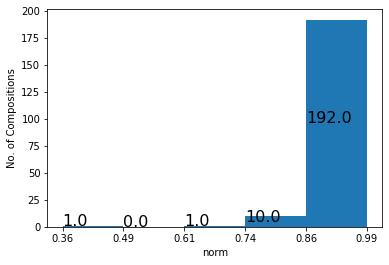

In [18]:
nbins = 5
column = 'norm'
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(lit.loc[lit.length >= min_length, column], bins = nbins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) # tick labels with two decimals
ax.set_xticks(bins)
for i in range(nbins):
    plt.text(bins[i],counts[i]/2,str(counts[i]), fontsize = 16)
plt.ylabel('No. of Compositions')
plt.xlabel(column)
plt.savefig(f'viz/hist_norm.png', bbox_inches='tight')

If we restrict the display to documents of at least 200 lemmas, the lowest scoring one is [The Sumerian King List](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.2.1.1&display=Crit&charenc=gcirc#), a rather repetitive text that lists cities, kings, and regnal years, with only occasionally a brief anecdote about one of those kings. Many of these king names are not found in the lexical corpus - hence the `norm` value of 0.36. But, as the histogram shows, this is exceptional, it is much more common to see a literary text with more than 90% of its lemmas represented in the lexical corpus.

#### 3.2.4.3 Dumuzid's Dream
In the Venn diagrams in 3.1 we saw that between 55% and 65% (depending on the way of counting) of the literary vocabulary is not attested in the lexical corpus. How can we square that outcome with the fact that the great majority of literary compositions shares more than 90% of their vocabulary with the lexical corpus? In order to explore that question we will look at a concrete example: the story of [Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#). In [epsd2/literary](http://oracc.org/epsd2/literary) this composition has the ID Q000347.

In [19]:
lit_df2[lit_df2.id_text == "Q000347"]

,id_text,designation,length,lex_var,n_matches,norm
533,Q000347,Dumuzid's dream,1146,274,258,0.941606


[Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#) has a `norm` value of 0.94, slightly above the median value of 0.92. The number means that 94% of the lemmas (and MWEs) in [Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#) are found in the lexical corpus. Which words are not found?

We have to go back to the data set as represented by `lit_lines` - this contains all words, lemmatized and unlemmatized, those represented in the lexical corpus and those not attested there. We select the lines that belong to [Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#) (Q000347), join the lines to a single string and then split this string at the blank spaces. This gives a list of all lemmas and MWEs in [Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#). We remove the unlemmatized forms and reduce the list to a set of unique elements.

In [20]:
DD = lit_lines[lit_lines.id_text.str[-7:] == "Q000347"]
DD_lemmas = ' '.join(DD['lemma_mwe']).split()
DD_lemmas = [l for l in DD_lemmas if not '[na]na' in l]
DD_lemmas_s = set(DD_lemmas)

We may now transform the list `lex_vocab` (which contains all lexical lemmas and MWEs) into a set, so that we can subtract one set from the other. The result (another set) contains all the items that are present in the first set (the vocabulary of [Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#)), but not in the other (the Old Babylonian lexical vocabulary).

In [21]:
lex_vocab_s = set(lex_vocab)
DD_lemmas_s - lex_vocab_s

{'amaŋeštinanak[1]dn',
 'arali[1]gn',
 'dubban[fence]n',
 'durtur[1]dn',
 'kubireš[1]gn',
 'kubirešdildareš[1]gn',
 'mašuzudak[goat]n',
 'men[go]v/i',
 'ne[cvne]n',
 'sug[full]v/i',
 'zipatum[cord]n',
 'ŋeštindudu[1]dn',
 'šarag[dry]v/t',
 'še[tear]n',
 'širkalkal[subscript]n',
 'šudu[handcuffs]n'}

Among the words, currenly not found in the lexical corpus, are a remarkable number of proper nouns: Divine Names (Amaŋeštinanak, Durtur, and Ŋeštindudu), and Geographical names (Arali, Kubireš, and Kubirešdildareš). The case of Arali is instructive. This word appears in OB Nippur Izi, but is lemmatized there as a noun (a word for the Netherworld), rather than as a Geographical Name. The goddess Amaŋeštinanak (**{d}ama-ŋeštin-an-na**) is well-attested in third millennium administartive texts and royal inscriptions, but is uncommon in the Old Babylonian period. In fact, the text of [Dumuzid's Dream](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.4.3&display=Crit&charenc=gcirc#) writes ama {d}ŋeštin-an-na "Mother Ŋeštinanak" - where "Mother" is an apparent honorific. Read that way, the word **ama** (mother) and the Divine Name **{d}ŋeštin-an-na** are present in the lexical corpus.

The word men\[go\]v/i is an Emesal word. Emesal is a variety of Sumerian that is used in cultic laments and in speeches by female divinities in Sumerian myths. Although the Old Babylonian lexical corpus includes some Emesal words, they are truly rare. Generally speaking, Emesal is associated with the liturgical use of Sumerian, whereas the scribal school focuses primarily on regular Sumerian.